RNN hand written with linear layers. When training, data is passed in to the RNN time-step by time-step manaully. Uses hardcore L2 regularization with both firing rate and weights regularization, uses hessian optimization, uses ReTanh function. DOES NOT TRAIN WELL

In [2]:
from scipy.io import loadmat
import numpy as np
import torch


In [3]:
monkey_data = loadmat('../monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]


In [4]:
test = np.zeros((502, 2))
for i, data in enumerate(visual_data):
    test[i] = data.shape

print(test[:,1].max())

341.0


In [5]:
batch_size = visual_data.shape[0] # N, 502
trial_len = int(test[:,1].max()) # visual_data[0].shape[1] # T, 298 
in_dim = visual_data[0].shape[0] # L, 21
out_dim = muscle_data[0].shape[0] # O, 50

hid_dim = 100
num_layers = 3

In [6]:
new_visual_data = np.zeros((batch_size, trial_len, in_dim))

for i, data in enumerate(visual_data):
    new_visual_data[i, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
print(new_visual_data.shape)

(502, 341, 21)


In [7]:
from sklearn.model_selection import train_test_split
# np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

train_input = np.zeros((int(batch_size * .8), trial_len, in_dim))
train_output = np.zeros((int(batch_size * .8), trial_len, out_dim))
test_input = np.zeros((int(np.ceil(batch_size * .2)), trial_len, in_dim))
test_output = np.zeros((int(np.ceil(batch_size * .2)), trial_len, out_dim))
train_ind = 0
test_ind = 0
for i, data in enumerate(visual_data):
     if i in train_idx:
       train_input[train_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
       train_output[train_ind, 0:visual_data[i].shape[1], :] = muscle_data[i].transpose()
       train_ind += 1
     else:
        test_input[test_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
        test_output[test_ind, 0:visual_data[i].shape[1], :] = muscle_data[i].transpose()
        test_ind += 1



- ReTanh activation function --> yes
- rate regularization: 1e-1 --> yes
- weight regularization: 1e-5 --> yes
- intermodule sparsity: 0.1 --> no
- Hessian free optimization --> yes
- birdirectional --> no

In [8]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)
    loss = torch.mean((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [11]:
from torch import nn

from mrnn import MilliesRNN
# from hessianfree import HessianFree

learning_rate = 0.00001
hessian = False


model = MilliesRNN(in_dim, hid_dim, out_dim, int(batch_size * .8))
criterion = nn.MSELoss() 
# criterion = hardcore_loss
"""if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)"""

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 3
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))

outputs = torch.zeros((int(batch_size * .8), trial_len, out_dim))
hiddens = torch.zeros((int(batch_size * .8), trial_len, hid_dim))

# change?? TODO
# train_input = torch.from_numpy(train_input).to(torch.float32)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # iteratring over time
    # hidden = model.init_hidden()

    """for i in range(trial_len):
        time_step = torch.from_numpy(train_input[:, i, :]).to(torch.float32) 
        real_output = torch.from_numpy(train_output[:, i, :]).to(torch.float32)

        gen_output, hidden = model(time_step, hidden)
        # hidden = hidden.detach()
        outputs[:, i, :] = gen_output
        hiddens[:, i, :] = hidden"""

    loss = criterion(outputs, torch.from_numpy(train_output).to(torch.float32))

    # loss = criterion(gen_output, real_output)
    # loss = criterion(gen_output, real_output, model.named_parameters())
    
    # nn.utils.clip_grad_norm_(model.parameters(), 1)
    
    loss.backward()
    optimizer.step()

    # hidden = hidden.detach()
    loss_error.append(loss.item())
    if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{i + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )

        """loss = criterion(gen_output, real_output)
        # loss = criterion(gen_output, real_output, model.named_parameters())
        
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output, _ = model(time_step, hidden)
            loss = criterion(gen_output, real_output)
            # loss = criterion(gen_output, real_output, model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        hidden = hidden.detach()
        loss_error.append(loss.item())
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_output)}], "
                f"Loss: {loss.item():.4f}"
            )"""



RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [46]:
len(loss_error) / 3

341.0

Text(0, 0.5, 'mse loss')

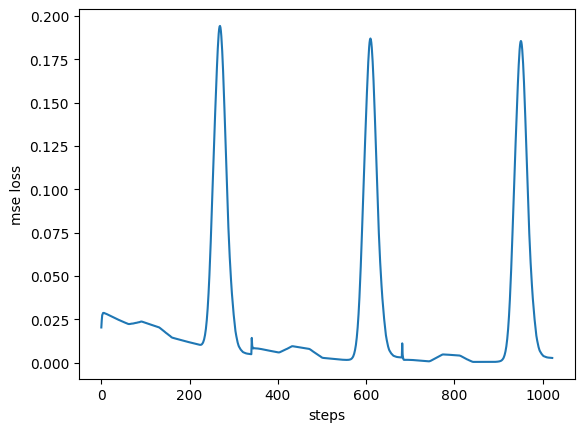

In [42]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("mse loss")

Text(0, 0.5, 'mse loss')

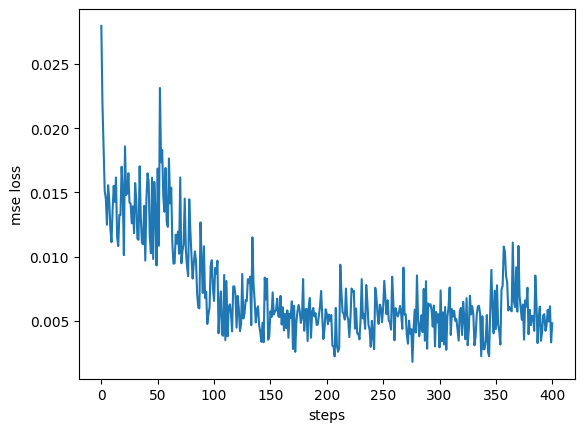

In [13]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

In [51]:
preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
# num_samples = len(test_dataset)

model.eval()


total_loss = 0
with torch.no_grad():
    hidden = model.init_hidden()

    for i in range(trial_len):
        time_step = torch.from_numpy(train_input[:, i, :]).to(torch.float32) 
        real_output = torch.from_numpy(train_output[:, i, :]).to(torch.float32)

        gen_output, hidden = model(time_step, hidden)
        loss = criterion(gen_output, real_output)
        total_loss += loss

print(f"Average test loss: {total_loss / 101}")

Average test loss: 0.06603111326694489
